### Desafío 1: Preparación de ambiente de trabajo
- Importe los módulos básicos para el análisis de datos.
- Importe las clases LabelEncoder , StandardScaler y LabelBinarizer de preprocessing
- Importe las funciones train_test_split y cross_val_score de model_selection
- Importe la función classification_report de metrics
- Importe las clases LinearDiscriminantAnalysis y QuadraticDiscriminantAnalysis .
- Agregue la base de datos en el ambiente de trabajo.
- Inspeccione la distribución de cada atributo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv("default_credit.csv").drop(columns='index')

In [3]:
df.columns

Index(['default', 'student', 'balance', 'income'], dtype='object')

In [4]:
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


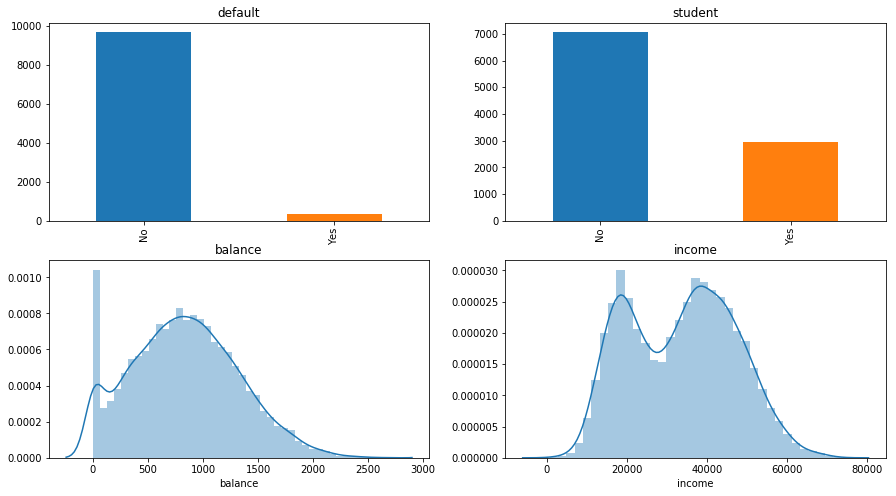

In [5]:
plt.figure(figsize=(15,8))
for idx, val in enumerate(df.columns):
    if(len(df[val].value_counts())<3):
        plt.subplot(2,2,idx+1)
        plt.title(val)
        df[val].value_counts().plot(kind='bar')
    else:
        plt.subplot(2,2,idx+1)
        plt.title(val)
        sns.distplot(df[val])
        

- `default`y `student`son variables binarias donde _No_ es el valor más común
- `balance`distribuye parecido a normal, pero con gran cantidad de valores cero
- `income` tiene dos valores máximos

### Desafío 2: Modelo base
- Recuerde que los modelos de sklearn no soportan datos que no sean numéricos.
- Transforme los atributos pertinentes con LabelEncoder .
- Genere muestras de validación y entrenamiento, reservando un 33% de los datos como validación.
- Genere un modelo con LinearDiscriminantAnalysis sin modificar los hiperparámetros.
- Genere métricas de evaluación utilizando classification_report .
- Comente sobre cuál es el desempeño del modelo en cada clase, así como en general.

In [6]:
df['default'] = LabelEncoder().fit_transform(df['default'])
df['student'] = LabelEncoder().fit_transform(df['student'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='default'), df['default'], test_size=.33,random_state=602)

In [8]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3181
           1       0.79      0.26      0.39       119

   micro avg       0.97      0.97      0.97      3300
   macro avg       0.88      0.63      0.69      3300
weighted avg       0.97      0.97      0.96      3300



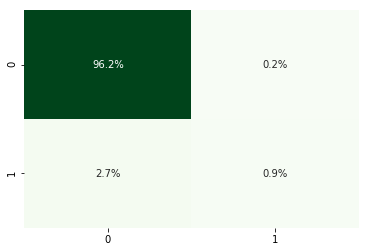

In [9]:
y_hat = lda_model.predict(X_test)

print(classification_report(y_test, y_hat))

target_label = df['default'].unique()
cnf = confusion_matrix(y_test, y_hat, target_label)/len(y_test)
sns.heatmap(cnf, xticklabels=target_label, yticklabels=target_label, annot=True, cmap='Greens', fmt=".1%", cbar=False)

- El modelo se desempeña bien para identificar _no_ `default`, pero falla para encontrar `default`

### Desafío 3: Refactorización 1 - información a priori
- Dado que trabajamos con modelos generativos, podemos incluír información exógena. Para este caso agregaremos dos distribuciones:
- Asumamos que hay un 50/50 de morosos y no morosos.
- Asumamos que hay un 60/40 de morosos y no morosos.
- Por cada modelo, reporte las métricas de clasificación.

In [10]:
prior=[0.50, 0.50]

lda_model_50 = LinearDiscriminantAnalysis(priors=prior)
lda_model_50.fit(X_train, y_train)

y_hat_50 = lda_model_50.predict(X_test)

print(classification_report(y_test, y_hat_50))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3181
           1       0.17      0.94      0.29       119

   micro avg       0.84      0.84      0.84      3300
   macro avg       0.58      0.89      0.60      3300
weighted avg       0.97      0.84      0.88      3300



In [11]:
prior=[0.40, 0.60]

lda_model_60 = LinearDiscriminantAnalysis(priors=prior)
lda_model_60.fit(X_train, y_train)

y_hat_60 = lda_model_60.predict(X_test)

print(classification_report(y_test, y_hat_60))

              precision    recall  f1-score   support

           0       1.00      0.78      0.87      3181
           1       0.14      0.97      0.25       119

   micro avg       0.78      0.78      0.78      3300
   macro avg       0.57      0.88      0.56      3300
weighted avg       0.97      0.78      0.85      3300



In [12]:
df['default'].value_counts()

0    9667
1     333
Name: default, dtype: int64

### Desafío 4: Refactorización 2 - oversampling
- Uno de los problemas más graves de esta base de datos, es el fuerte desbalance entre clases. Ahora generaremos observaciones sintéticas mediante SMOTE (Synthetic Minority Oversampling Technique). Para ello, debemos agregar el paquete a nuestro ambiente virtual.
- En nuestro terminal agregamos conda install -c conda-forge imbalanced-learn .
- Incorpore SMOTE en el ambiente de trabajo con la siguiente sintáxis from imblearn.over_sampling import SMOTE .
- Para implementar oversampling, debemos generar nuevos objetos que representan nuestra muestra de entrenamiento incrementada artificialmente. Para ello implemente la siguiente sintáxis:
- Vuelva a entrenar el modelo con los datos aumentados de forma artificial y comente sobre su desempeño.

In [13]:
oversampler = SMOTE(random_state=602, ratio='minority')
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)

In [14]:
lda_model_os = LinearDiscriminantAnalysis()
lda_model_os.fit(X_train_oversamp, y_train_oversamp)


y_hat_os = lda_model_os.predict(X_test)

print(classification_report(y_test, y_hat_os))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3181
           1       0.17      0.95      0.30       119

   micro avg       0.84      0.84      0.84      3300
   macro avg       0.59      0.89      0.60      3300
weighted avg       0.97      0.84      0.89      3300



### Desafío 5: Refactorización 3 - QDA
- Por último, implemente un modelo QuadraticDiscriminantAnalysis con los datos aumentados artificialmente. Genere las métricas de desempeño.
- Comente a grandes rasgos sobre el mejor modelo en su capacidad predictiva.

In [15]:
qda_model_os = QuadraticDiscriminantAnalysis()
qda_model_os.fit(X_train_oversamp, y_train_oversamp)


y_hat_qos = qda_model_os.predict(X_test)

print(classification_report(y_test, y_hat_qos))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92      3181
           1       0.20      0.93      0.32       119

   micro avg       0.86      0.86      0.86      3300
   macro avg       0.60      0.89      0.62      3300
weighted avg       0.97      0.86      0.90      3300



In [16]:
def class_report(model, xtrain, ytrain, xtest, ytest):
    y_hat = model.predict(xtest)
    print(classification_report(ytest, y_hat))
    
    return pd.DataFrame(classification_report(ytest, y_hat, output_dict=True)).drop(columns=['micro avg', 'macro avg', 'weighted avg'])

    
    
    

In [28]:
lda = class_report(lda_model, X_train, y_train, X_test, y_test)
lda_50 = class_report(lda_model_50, X_train, y_train, X_test, y_test)
lda_60 = class_report(lda_model_60, X_train, y_train, X_test, y_test)
lda_os = class_report(lda_model_os, X_train_oversamp, y_train_oversamp, X_test, y_test)
qda_os = class_report(qda_model_os, X_train_oversamp, y_train_oversamp, X_test, y_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3181
           1       0.79      0.26      0.39       119

   micro avg       0.97      0.97      0.97      3300
   macro avg       0.88      0.63      0.69      3300
weighted avg       0.97      0.97      0.96      3300

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3181
           1       0.17      0.94      0.29       119

   micro avg       0.84      0.84      0.84      3300
   macro avg       0.58      0.89      0.60      3300
weighted avg       0.97      0.84      0.88      3300

              precision    recall  f1-score   support

           0       1.00      0.78      0.87      3181
           1       0.14      0.97      0.25       119

   micro avg       0.78      0.78      0.78      3300
   macro avg       0.57      0.88      0.56      3300
weighted avg       0.97      0.78      0.85      3300

              preci

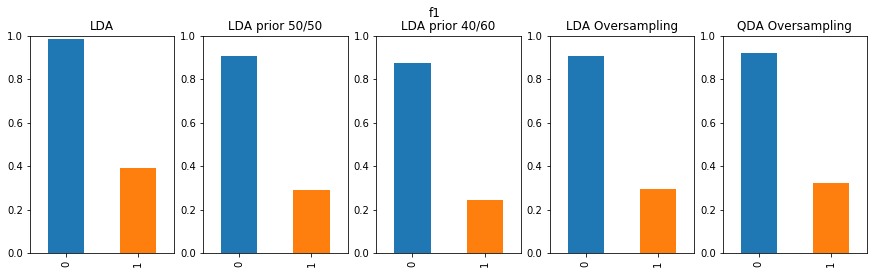

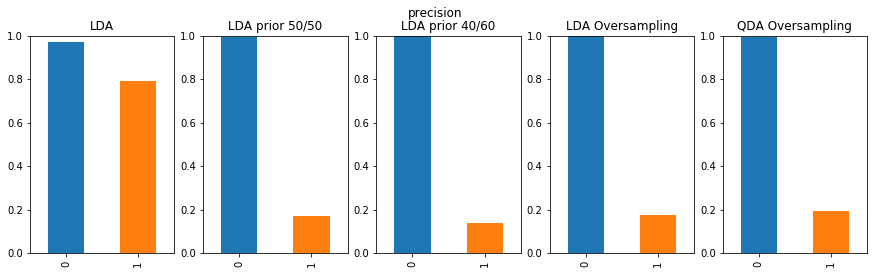

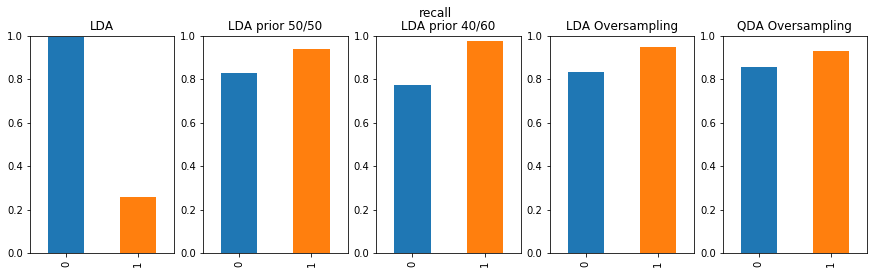

In [70]:
for index, val in enumerate(['f1', 'precision', 'recall']):
    plt.figure(figsize=(15,4))
    plt.suptitle(val)

    plt.subplot(1,5,1)
    plt.title('LDA')
    plt.ylim(0, 1)
    lda.iloc[index].plot(kind='bar')
    
    plt.subplot(1,5,2)
    plt.title('LDA prior 50/50')
    plt.ylim(0, 1)
    lda_50.iloc[index].plot(kind='bar')
    
    plt.subplot(1,5,3)
    plt.title('LDA prior 40/60')
    plt.ylim(0, 1)
    lda_60.iloc[index].plot(kind='bar')
    
    plt.subplot(1,5,4)
    plt.title('LDA Oversampling')
    plt.ylim(0, 1)
    lda_os.iloc[index].plot(kind='bar')
   
    plt.subplot(1,5,5)
    plt.title('QDA Oversampling')
    plt.ylim(0, 1)
    qda_os.iloc[index].plot(kind='bar')
    

- El mejor modelo es el primero LDA, debido a que tiene el mejor valor de _f1_ tanto para predecir morosos como no morosos
- Los otros modelos tienen un _recall_ más alto para predecir default, es decir, logran identificar positivamente

- 